<a href="https://colab.research.google.com/github/mbensouda/NoisET_tutorial/blob/main/Part_1_understanding_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inferring responding immune clonotypes

**Question**: how can we identify the Tcells receptors of the immune system that *significantly* respond to a disease? (Here we will look at COVID)

**Approach**: we are going to use the NoisET software, that learns a model for the experimental and sampling noise through replicates, and uses this information to detect significantly expanded clonotypes of T cells.

NoisET repository: 

https://github.com/statbiophys/NoisET

For more detailed information: 

https://arxiv.org/abs/2102.03568, 

https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007873

\\


### Plan for the tutorial: 
- **Familiarize with longitudinal data of T Cell Recepors**. We will import samples of TCRs taken at different time points in a COVID infected individual. We will compute a few basic statistics of this dataset, which show the huge diverity and complexity of our immune system.
- **Learning the noise across replicates**. The dataset contains also samples of TCR taken at the same time. Although these samples shouldn't be *biologically* different, they actually differ. These differences are due to the fact that we are sampling a small fraction of Tcells in our body. We will use the first NoisET functionality to quantify this sampling noise.
- **Inferring the contracted clonotypes**. If we instead consider samples at different time points, we expect that the immune system has evolved and its composition has changed (in our case because of COVID).
To identify which Tcell clonotypes show a significant variation and, therefore, have interacted with the disease, we will employ the second main function of NoisET. 
Note that, just because of the sampling noise seen before, some clonotypes can change in abundance and can be wrongly classified as biologically relevant.
However NoisET takes into account the noise model that we learned at the previous step and "subtracts" its effect in this enrichment analysis.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Part 1 - Familiarize with longitudinal data of T Cell Recepors

### 1.1 Importing the dataset

In [ ]:
# Syncronising the local drive folder with colab
# The folder containing the data that we shared with you must be 
# linked to your personal google Drive (right click -> Add shortcut to Drive)
# After running the cell allow the notebook to accede to your Drive.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


After having sync your Drive, the dataset should be located in '/content/drive/MyDrive/COVID_noiset/data/'.

The two folders in the data directory, alpha and beta, refer to sequences belonging to the alpha or the beta chain of the sampled T-cell receptors (https://en.wikipedia.org/wiki/T-cell_receptor). You can choose one of the two for carrying out your tutorial.

In each folder the data are organised into tables that we are going to import.
The name of the file is composed of two capital letters, which are the acronyms of the patient, a number, which is the number of days after the infection and F1/F2, which label the two different sample replicates at the same day for the same patient.

Below those tables are imported and stored in a dictionary, where the keys are string specifying the patient, th time and the replicate.
The values are pandas dataframes, imported through command `read_csv` https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html.
It is useful to know also the command `os.listdir` (after having imported `os`) for iterating among all the file names in a directory.

In [ ]:
import os

def import_clones(patient, data_folder):
  """ 
  Function that imports all the clonotypes of a given patient and stores
  them in a dictionary. It returns also the list of ordered time points
  of such tables.
  """

  times = []
  clones = dict()

  # Iteration over all the file in the folder
  for file_name in os.listdir(data_folder):
    # If the name before the underscore corresponds to the chosen patient..
    if file_name.split('_')[0] == patient:
      # Import the table
      frame = pd.read_csv(data_folder+file_name, sep='\t')
      # Store it in a dictionary where the key contains the patient, the time
      # and the replicate.
      clones[file_name[:-10]] = frame
      # Reading the time from the name and storing it
      times.append(int(file_name.split('_')[1]))
      print('Clonotypes',file_name[:-10],'imported')

  # Sorting the unique times
  times = np.sort(list(set(times)))
  return clones, times


data_folder_b = '/content/drive/MyDrive/COVID_noiset/data/beta/'
patient = 'MP'

clones, times = import_clones(patient, data_folder_b)
print()
print('Time points: ', times)

Clonotypes MP_15_F1 imported
Clonotypes MP_15_F2 imported
Clonotypes MP_30_F1 imported
Clonotypes MP_30_F2 imported
Clonotypes MP_37_F1 imported
Clonotypes MP_37_F2 imported
Clonotypes MP_45_F1 imported
Clonotypes MP_45_F2 imported
Clonotypes MP_80_F1 imported
Clonotypes MP_80_F2 imported

Time points:  [15 30 37 45 80]


Display one of these tables and check the different fields. Here we focus on the nucleotide string, identifying a clonotype with that sequence.
For this tutorial we will ignore the amino-acid translation of that sequence.

In [ ]:
clones['MP_15_F1']

,N. Seq. CDR3,AA. Seq. CDR3,Clone count,Clone fraction
0,TGTGCCAGCAGCGCCCCAGCGGGGGTCGGCGAGCAGTACTTC,CASSAPAGVGEQYF,89845,4.600179e-02
1,TGTGCCAGCAGCCCAAGGGCAGGGAAGGGTGAGCAGTTCTTC,CASSPRAGKGEQFF,77377,3.961802e-02
2,TGTGCCAGCAGTTTTTGGACACCCTACGAGCAGTACTTC,CASSFWTPYEQYF,50247,2.572711e-02
3,TGTGCCAGCAGCCCGCCGGGACAGCACAATGAGCAGTTCTTC,CASSPPGQHNEQFF,42087,2.154908e-02
4,TGTGCCAGCAGCTTGGAAGGGTACGGGACGCCGGCTGAAGCTTTCTTT,CASSLEGYGTPAEAFF,31322,1.603727e-02
...,...,...,...,...
552405,TGTGCCAGCGGC,CASG,1,5.120128e-07
552406,TGTGCCAGCACC,CAST,1,5.120128e-07
552407,TGTACCCTGGGC,CTLG,1,5.120128e-07
552408,TGTAGACTCTTC,CRLF,1,5.120128e-07


**Task: how many different clonotypes are present in each table?**

To iterate over a dictionary it's useful to use `clones.items()`.

In [ ]:
#[LEAVE EMPTY AS EXERCISE]

for id_, frame in clones.items():
  print('The unique clonotypes in', id_, 'are', len(frame))

The unique clonotypes in MP_15_F1 are 552410
The unique clonotypes in MP_15_F2 are 375859
The unique clonotypes in MP_30_F1 are 588152
The unique clonotypes in MP_30_F2 are 554467
The unique clonotypes in MP_37_F1 are 483907
The unique clonotypes in MP_37_F2 are 503318
The unique clonotypes in MP_45_F1 are 717660
The unique clonotypes in MP_45_F2 are 796470
The unique clonotypes in MP_80_F1 are 565639
The unique clonotypes in MP_80_F2 are 556222


### 1.2 - Statistics of clonotype abundance

It is known that the distribution of counts of clonotypes follow a power law with exponent -2.
Here we want to check that our data are meaningful and follow this prediction.

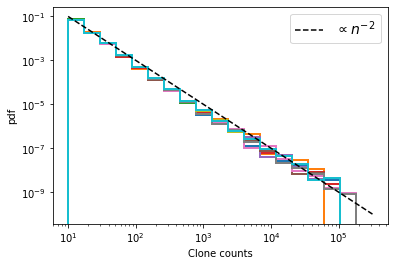

In [ ]:
# Logarithmic double scale
plt.yscale('log')
plt.xscale('log')

plt.xlabel('Clone counts')
plt.ylabel('pdf')

# Plotting all the count distribution of all the tables
bins = np.logspace(1,5.5,20)
for id_, cl in clones.items():
  h=plt.hist(cl["Clone count"], log=True, density=True, bins=bins, histtype='step', lw=2)

# As a check, we plot the power law with exponent -2
plt.plot(bins, 10*bins**(-2), c='black', ls='--', label=r'$\propto n^{-2}$')
plt.legend(fontsize=14)

### 1.3 Clonotype persistence at different time points

Here we address the following question: are the clonotypes persistent through time points (i.e. the same sequence appears at multiple times)?
To this end, we want to count in how many time points each clonotype appears. Let's call this variable *time occurrence*.

But first, we want to perform this analysis after collapsing the first and second replicate of each time point in one single table.

In [ ]:
# creating the dataframes for the merged replicates. After this operation the 
# clones_merged dictionary contains the the merged table of the first and second
# replicate. The indexes are the same as before without the F1/2 label.

clones_merged = dict()

# Iteration over the times
for it, t in enumerate(times):
  # Building the ids correponding at 1st and 2nd replicate at given time point
  id_F1 = patient + '_' + str(t) + '_F1'
  id_F2 = patient + '_' + str(t) + '_F2'
  # Below all the rows of one table are appended to the rows of the other
  merged_replicates = clones[id_F1].merge(clones[id_F2], how='outer')
  # But there are common clonotypes that now appear in two different rows 
  # (one for the first and one for the second replicate)! 
  # Below we collapse those common sequences and the counts of the two are summed 
  merged_replicates = merged_replicates.groupby('N. Seq. CDR3', as_index=False).agg({'Clone count':sum})
  # The merged table is then added to the dictionary
  clones_merged[patient + '_' + str(t)] = merged_replicates

In [ ]:
#[LEAVE EMPTY AS EXERCISE]

for it, t in enumerate(times):
  id_F1 = patient + '_' + str(t) + '_F1'
  id_F2 = patient + '_' + str(t) + '_F2'
  seqs1 = set(clones[id_F1]['N. Seq. CDR3'].values)
  seqs2 = set(clones[id_F2]['N. Seq. CDR3'].values)
  comm_seqs = seqs1.intersection(seqs2)
  print('At time', t, len(comm_seqs), 'are in common over', len(seqs1)+len(seqs2), 'total sequences')

At time 15 63088 are in common over  928269 total sequences
At time 30 61059 are in common over  1142619 total sequences
At time 37 61384 are in common over  987225 total sequences
At time 45 83931 are in common over  1514130 total sequences
At time 80 63283 are in common over  1121861 total sequences


The task consists in **counting, for each unique clonotype, in how many time points it is present, i.e. its time occurrence**.
As a facultative task, you can repeat the analysis by merging the first and the second replicates in one single big table for each time point.

There are multiple ways of computing this numbers in python.
Try to think about it by yourself.
A possible suggestion could be to use the function `unique` of numpy with the option `return_counts=True` (https://numpy.org/doc/stable/reference/generated/numpy.unique.html).

In [ ]:
all_clones = np.array([])
for id_, cl in clones.items():
  # Below only the merged-replicate tables are selected
  if len(id_.split('_')) == 2:
    all_clones = np.append(all_clones, cl['N. Seq. CDR3'].values)

unique_clones, time_occurrence = np.unique(all_clones, return_counts = True)

**Plot the istogram of these time occurrences**, what can you conclude from it?

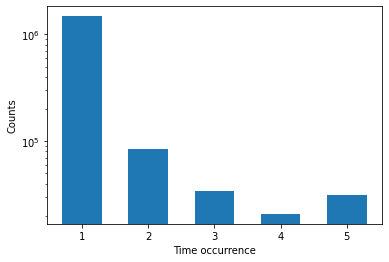

In [ ]:
plt.yscale('log')
plt.xlabel('Time occurrence')
plt.ylabel('Counts')
h=plt.hist(time_occurrence, bins=np.arange(1,len(times)+2)-0.5, rwidth=0.6)

### 1.3 Facultative task

Let us define the total counts of a unique clonotype as the summation of all the counts in all the time steps.
Then try to answer to the following question: **are the total counts related with the time occurrences?**
In other words, do I expect that a clone that appears in all the time points is also very abundant? 

In [ ]:
# Total counts and time occurrence computed through merging and groupby

merged_clones = pd.DataFrame(columns=['N. Seq. CDR3', 'Clone count'])
for id_, cl in clones.items():
  if len(id_.split('_')) == 2:
    merged_clones = merged_clones.merge(cl, how='outer')

merged_clones['Time occurrence'] = 1
merged_clones = merged_clones.groupby('N. Seq. CDR3').agg({'Clone count':sum, 'Time occurrence':sum})

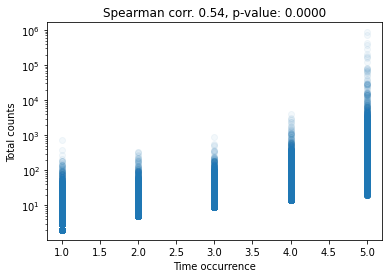

In [ ]:
from scipy.stats import spearmanr
corr_coef, p_val = spearmanr(merged_clones['Time occurrence'], merged_clones['Clone count'])

plt.title('Spearman corr. %3.2f, p-value: %5.4f' %(corr_coef, p_val))
plt.xlabel('Time occurrence')
plt.ylabel('Total counts')
plt.yscale('log')
plt.scatter(merged_clones['Time occurrence'], merged_clones['Clone count'], alpha=0.05)

### 1.4 Trajectories of clonotypes

**Here we want to plot the time trajectories of the 100 most abundant clonotypes of each time point.** Again you can focus only on the first replicates and ignore F2 (as a facultative task you can include also the second relicates by merging the first and the second replicates in one single big table).

TODO


In [ ]:
def get_top_clones_set(n_top_clones, min_n_top_clones=0):
  top_clones = set()
  for it, t in enumerate(times):
    id_ = patient + '_' + str(t)
    top_clones_at_time = clones[id_].sort_values('Clone count', ascending=False)[min_n_top_clones:n_top_clones]
    top_clones = top_clones.union(top_clones_at_time['N. Seq. CDR3'].values)
  return top_clones

def build_traj_frame(top_clones_set):
  traj_frame = pd.DataFrame(index=top_clones_set)
  traj_frame['Clone cumul count'] = 0
  for it, t in enumerate(times):
    id_ = patient + '_' + str(t)
    
    top_clones_at_time = top_clones_set.intersection(set(clones[id_]['N. Seq. CDR3']))
    clones_at_time = clones[id_].set_index('N. Seq. CDR3').loc[top_clones_at_time]
    traj_frame['t'+str(it)] = traj_frame.index.map(clones_at_time['Clone count'].to_dict())
    traj_frame = traj_frame.fillna(0)
    traj_frame['Clone cumul count'] += traj_frame['t'+str(it)]
  return traj_frame

In [ ]:
top_clones = get_top_clones_set(200)
traj_frame = build_traj_frame(top_clones)

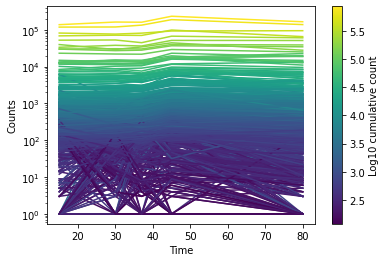

In [ ]:
from matplotlib import cm, colors, colorbar
cmap = cm.get_cmap('viridis')

plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Counts')
log_counts = np.log10(traj_frame['Clone cumul count'].values)
max_log_count = max(log_counts)
min_log_count = min(log_counts)
for id_, row in traj_frame.iterrows():
  traj = row[['t0', 't1', 't2', 't3', 't4']].to_numpy()
  log_count = np.log10(row['Clone cumul count'])
  norm_log_count = (log_count-min_log_count)/(max_log_count-min_log_count)
  plt.plot(times, traj+1, c=cmap(norm_log_count))


sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(log_counts), vmax=max(log_counts)))
cb = plt.colorbar(sm)
cb.set_label('Log10 cumulative count')

### 1.5 Making some sense of these trajectories: PCA

We can try to address the previous observation in a more systematic way: can we identify clusters of trajectories that follow a simila pattern (e.g. finding the ones that dacay)?

To this end we want to reduce the dimensions of the trajectories through PCA.

First, we need to select only the most abundant clonotypes. A good criteria is to **select all the clonotypes that are among the top 1000 abundant sequences in at least one time point**.
In other words, for each time point we want to isolate the top 1000 clonotypes.


In [ ]:
top_clones = get_top_clones_set(1000)
traj_frame = build_traj_frame(top_clones)
traj_matrix = traj_frame[['t0', 't1', 't2', 't3', 't4']].to_numpy()
norm_traj_matrix = traj_matrix/np.max(traj_matrix, axis=1)[:,np.newaxis]

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

pca = PCA(n_components=2).fit(norm_traj_matrix.T)
clustering = AgglomerativeClustering(n_clusters=3)
clustering = clustering.fit(pca.components_.T)

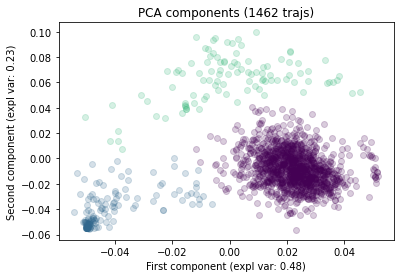

In [ ]:
plt.title('PCA components (%i trajs)' %len(norm_traj_matrix))
plt.xlabel('First component (expl var: %3.2f)'%pca.explained_variance_ratio_[0])
plt.ylabel('Second component (expl var: %3.2f)'%pca.explained_variance_ratio_[1])
for c_ind in range(clustering.n_clusters):
    x = pca.components_[0][clustering.labels_ == c_ind]
    y = pca.components_[1][clustering.labels_ == c_ind]
    plt.scatter(x, y, alpha=0.2, color=cmap(c_ind/clustering.n_clusters))

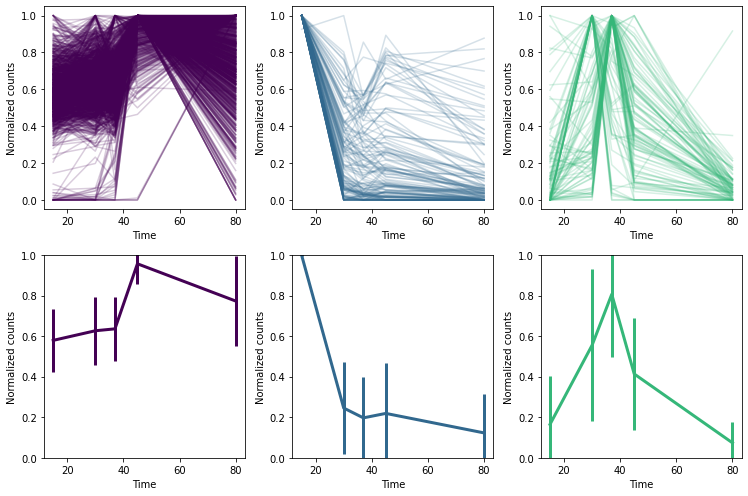

In [ ]:
n_cl = clustering.n_clusters

fig, axs = plt.subplots(2, n_cl, figsize=(3.5*n_cl, 7))
for cl in range(n_cl):
    trajs = norm_traj_matrix[clustering.labels_ == cl]
    axs[0][cl].set_xlabel('Time')
    axs[0][cl].set_ylabel('Normalized counts')
    axs[1][cl].set_xlabel('Time')
    axs[1][cl].set_ylabel('Normalized counts')
    for traj in trajs:
        axs[0][cl].plot(times, traj, alpha=0.2, color=cmap(cl/n_cl))
    axs[1][cl].set_ylim(0,1)
    axs[1][cl].errorbar(times, np.mean(trajs, axis=0), 
                        yerr=np.std(trajs, axis=0), lw=3, color=cmap(cl/n_cl))
    #axs[1][cl].fill_between(times, np.quantile(trajs, 0.75, axis=0), np.quantile(trajs, 0.25, axis=0), color=colors[cl])
        
plt.tight_layout()

## Part 2 - Learning the noise across replicates

## Part 3 - Inferring the contracted clonotypes